# KNN - Distributed & Sequential (Shabbir Kutbuddin)

## Distributed KNN Classification on Time Series Data Using Apache Spark

This notebook performs K-Nearest Neighbors (KNN) classification on the FordA time series dataset using PySpark. 
It compares Euclidean distance with DTW (Dynamic Time Warping) across different partition sizes and training data fractions.

### K=5

1. Setup & Imports

In [0]:
%pip install fastdtw
from pyspark.sql import SparkSession
from pyspark import SparkContext
import numpy as np
import time
import matplotlib.pyplot as plt
from fastdtw import fastdtw  # Fast approximation of DTW

# Initialize Spark context (assumes Spark session is already created)
sc = spark.sparkContext


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=470354 sha256=cb8ee4628d2b86de690bc9ad2bf717a7656ea2f36d0b91963d5ab9bffd6362cf
  Stored in directory: /home/spark-94c53807-3ad3-4547-aa20-da/.cache/pip/wheels/b2/b2/20/c0960e8ee3ceaf158c43f28eea50357113dfe2f3106da9fdb1
Successfully built fastdtw
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


2. Load and Preprocess the Dataset - Data is Z-normalized and does not need scaling


In [0]:
# Define dataset path
data_path = "/mnt/2025-team19/"

# Read CSV files into DataFrames
train_df = spark.read.csv(data_path + "FordA_TRAIN.csv", header=True, inferSchema=True)
test_df = spark.read.csv(data_path + "FordA_TEST.csv", header=True, inferSchema=True)

# Convert each row to (label, time_series_array) for both training and test sets
train_rdd = train_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 500)]))
test_rdd = test_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 500)]))


3. Distance Functions

In [0]:
# Euclidean distance (baseline metric)
def euclidean_distance(ts1, ts2):
    return float(np.sqrt(np.sum((np.array(ts1) - np.array(ts2))**2)))

# DTW distance using fastdtw (for alignment-insensitive comparison)
def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2)
    return float(distance)

4. Distributed KNN Function

In [0]:
# KNN with training RDD partitioned and broadcasted to avoid nested RDD operations
def distributed_knn(train_rdd, test_rdd, num_partitions, k=5, dist_func=euclidean_distance):
    """
    Perform distributed KNN classification using broadcasted training partitions.
    
    Args:
        train_rdd: RDD of (label, features)
        test_rdd: RDD of (label, features)
        num_partitions: Number of partitions for training data
        k: Number of neighbors
        dist_func: Distance function (Euclidean or DTW)

    Returns:
        RDD of (true_label, predicted_label)
    """

    # 1. Randomly partition training data into groups
    partitioned_train = (
        train_rdd
        .map(lambda x: (np.random.randint(0, num_partitions), x))
        .groupByKey()
        .mapValues(list)
        .collectAsMap()
    )

    # 2. Broadcast the partitioned training data to all workers
    broadcast_partitions = sc.broadcast(partitioned_train)

    # 3. Predict function for test samples
    def predict(test_case):
        test_label, test_features = test_case
        partition_id = np.random.randint(0, num_partitions)
        candidates = broadcast_partitions.value.get(partition_id, [])
        
        if not candidates:
            return (test_label, -1)  # Return dummy prediction if partition is empty

        # Compute distances to candidates
        distances = [
            (dist_func(test_features, features), label)
            for (label, features) in candidates
        ]

        # Select top-k closest neighbors
        top_k = sorted(distances, key=lambda x: x[0])[:k]
        labels = [label for (_, label) in top_k]

        # Return most common label
        return (test_label, max(set(labels), key=labels.count))

    return test_rdd.map(predict)

5. Experiment Configuration

In [0]:
# Define experiment settings
fractions = [0.25, 0.5, 0.75, 1.0]       # Fractions of training data to sample
partitions = [2, 4, 8, 16]               # Partition counts
results = []                             # Store results (accuracy, time, etc.)

6. Main Experiment Loop

In [0]:
for frac in fractions:
    for num_parts in partitions:
        # Sample a subset of the training data
        subset = train_rdd.sample(False, frac, seed=42)

        
        # Run KNN using both distance functions
        for dist_name, dist_func in [('Euclidean', euclidean_distance),
                                     ('DTW', dtw_distance)]:
            # Time execution
            start_time = time.time()
            predictions = distributed_knn(
                subset,
                test_rdd,
                num_partitions=num_parts,
                k=5,
                dist_func=dist_func
            )

            # Evaluate accuracy
            correct = predictions.filter(lambda x: x[0] == x[1]).count()
            accuracy = correct / test_rdd.count()

            # Record average time
            duration = (time.time() - start_time)

            # Save results
            results.append({
                'Fraction': frac,
                'Partitions': num_parts,
                'Distance': dist_name,
                'Accuracy': accuracy,
                'Time': duration
            })

7.Visualisation of Results 

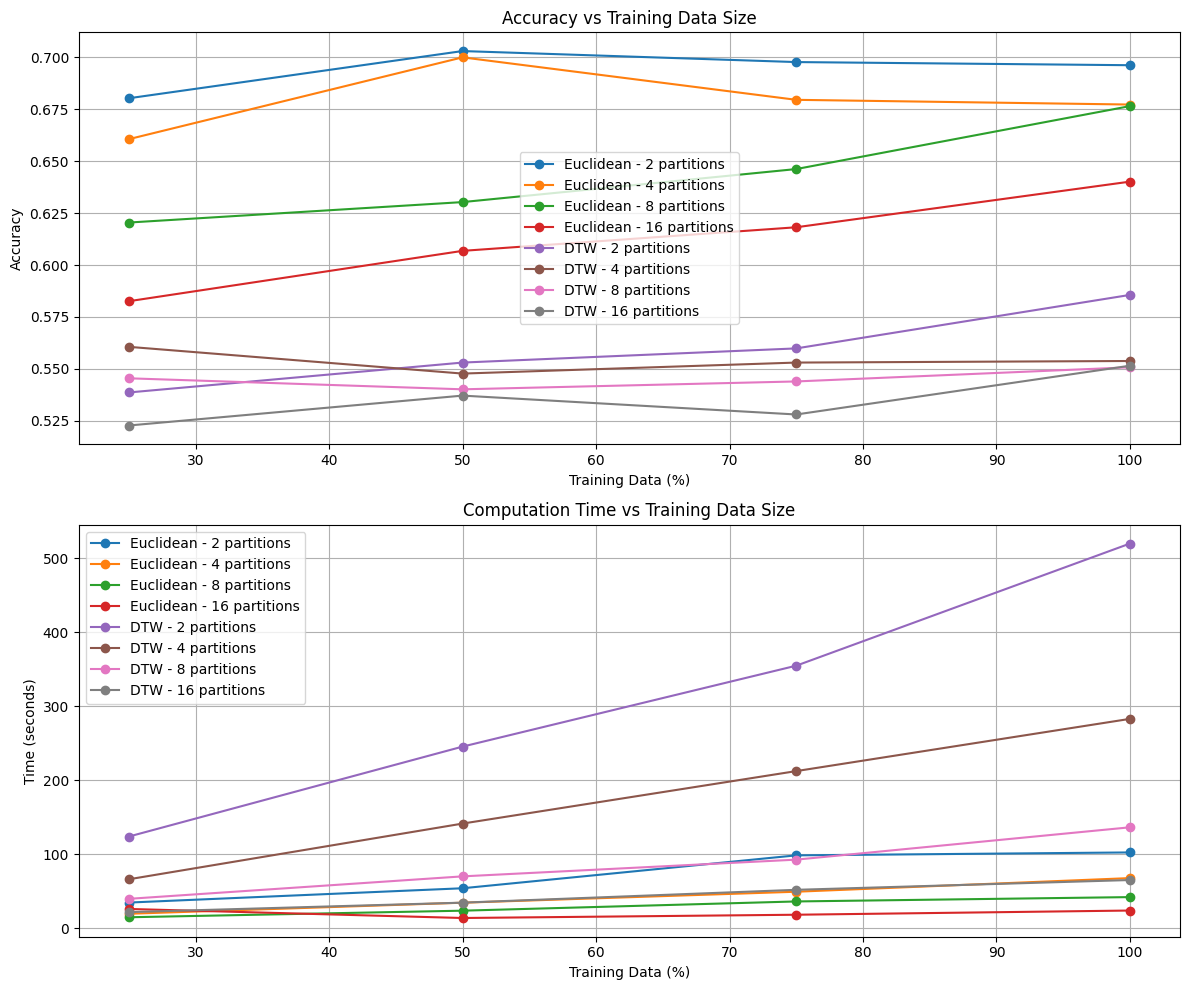

In [0]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# 🔹 Plot Accuracy
for dist_name in ['Euclidean', 'DTW']:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        y = [r['Accuracy'] for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        axs[0].plot(x, y, marker='o', 
                   label=f'{dist_name} - {num_parts} partitions')
axs[0].set_title('Accuracy vs Training Data Size')
axs[0].set_xlabel('Training Data (%)')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Plot Computation Time
for dist_name in ['Euclidean', 'DTW']:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        y = [r['Time'] for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        axs[1].plot(x, y, marker='o', 
                   label=f'{dist_name} - {num_parts} partitions')
axs[1].set_title('Computation Time vs Training Data Size')
axs[1].set_xlabel('Training Data (%)')
axs[1].set_ylabel('Time (seconds)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

8. Results Table

In [0]:
# Print experiment results in markdown-style table
print("| Fraction | Partitions | Distance   | Accuracy | Time (s) |")
print("|----------|------------|------------|----------|----------|")
for r in sorted(results, key=lambda x: (x['Distance'], x['Fraction'], x['Partitions'])):
    print(f"| {r['Fraction']*100:6.1f}% | {r['Partitions']:10} | {r['Distance']:10} | {r['Accuracy']:.4f}  | {r['Time']:8.2f} |")

| Fraction | Partitions | Distance   | Accuracy | Time (s) |
|----------|------------|------------|----------|----------|
|   25.0% |          2 | DTW        | 0.5386  |   124.15 |
|   25.0% |          4 | DTW        | 0.5606  |    66.41 |
|   25.0% |          8 | DTW        | 0.5455  |    39.99 |
|   25.0% |         16 | DTW        | 0.5227  |    22.03 |
|   50.0% |          2 | DTW        | 0.5530  |   245.69 |
|   50.0% |          4 | DTW        | 0.5477  |   141.69 |
|   50.0% |          8 | DTW        | 0.5402  |    70.35 |
|   50.0% |         16 | DTW        | 0.5371  |    34.82 |
|   75.0% |          2 | DTW        | 0.5598  |   355.07 |
|   75.0% |          4 | DTW        | 0.5530  |   212.61 |
|   75.0% |          8 | DTW        | 0.5439  |    92.95 |
|   75.0% |         16 | DTW        | 0.5280  |    52.17 |
|  100.0% |          2 | DTW        | 0.5856  |   520.11 |
|  100.0% |          4 | DTW        | 0.5538  |   283.20 |
|  100.0% |          8 | DTW        | 0.5508  |   13

### K=3

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


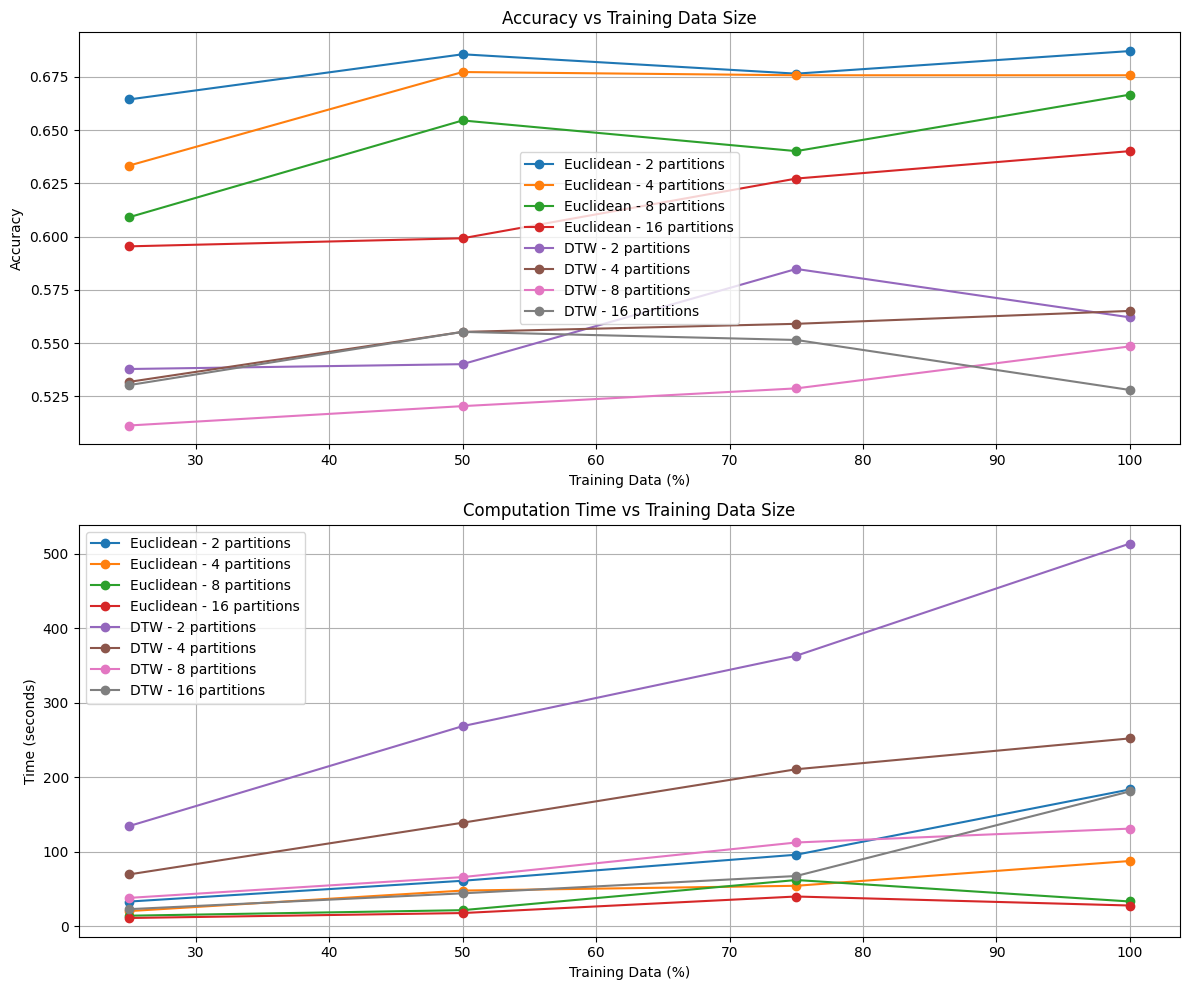

| Fraction | Partitions | Distance   | Accuracy | Time (s) |
|----------|------------|------------|----------|----------|
|   25.0% |          2 | DTW        | 0.5379  |   134.40 |
|   25.0% |          4 | DTW        | 0.5318  |    69.56 |
|   25.0% |          8 | DTW        | 0.5114  |    38.10 |
|   25.0% |         16 | DTW        | 0.5303  |    22.96 |
|   50.0% |          2 | DTW        | 0.5402  |   268.62 |
|   50.0% |          4 | DTW        | 0.5553  |   139.00 |
|   50.0% |          8 | DTW        | 0.5205  |    66.00 |
|   50.0% |         16 | DTW        | 0.5553  |    44.22 |
|   75.0% |          2 | DTW        | 0.5848  |   363.16 |
|   75.0% |          4 | DTW        | 0.5591  |   210.79 |
|   75.0% |          8 | DTW        | 0.5288  |   112.46 |
|   75.0% |         16 | DTW        | 0.5515  |    67.47 |
|  100.0% |          2 | DTW        | 0.5621  |   513.75 |
|  100.0% |          4 | DTW        | 0.5652  |   252.20 |
|  100.0% |          8 | DTW        | 0.5485  |   13

In [0]:
%pip install fastdtw
from pyspark.sql import SparkSession
from pyspark import SparkContext
import numpy as np
import time
import matplotlib.pyplot as plt
from fastdtw import fastdtw

# Initialize Spark
sc = spark.sparkContext

# Data Loading
data_path = "/mnt/2025-team19/"
train_df = spark.read.csv(data_path + "FordA_TRAIN.csv", header=True, inferSchema=True)
test_df = spark.read.csv(data_path + "FordA_TEST.csv", header=True, inferSchema=True)

# Prepare RDDs
train_rdd = train_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 501)]))
test_rdd = test_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 501)]))

# Distance functions
def euclidean_distance(ts1, ts2):
    return float(np.sqrt(np.sum((np.array(ts1) - np.array(ts2))**2)))

def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2)
    return float(distance)

def distributed_knn(train_rdd, test_rdd, num_partitions, k=3, dist_func=euclidean_distance):
    # 1. Prepare partitioned training data
    partitioned_train = (
        train_rdd
        .map(lambda x: (np.random.randint(0, num_partitions), x))
        .groupByKey()
        .mapValues(list)
        .collectAsMap()
    )
    
    # 2. Broadcast partitions to workers
    broadcast_partitions = sc.broadcast(partitioned_train)
    
    # 3. Process test cases using broadcasted data
    def predict(test_case):
        test_label, test_features = test_case
        partition_id = np.random.randint(0, num_partitions)
        candidates = broadcast_partitions.value.get(partition_id, [])
        
        if not candidates:
            return (test_label, -1)  # Handle empty partitions
        
        distances = [
            (dist_func(test_features, features), label)
            for (label, features) in candidates
        ]
        top_k = sorted(distances, key=lambda x: x[0])[:k]
        labels = [label for (_, label) in top_k]
        return (test_label, max(set(labels), key=labels.count))
    
    return test_rdd.map(predict)

# Experiment parameters
fractions = [0.25, 0.5, 0.75, 1.0]
partitions = [2, 4, 8, 16]
results = []

# Main experiment loop
for frac in fractions:
    for num_parts in partitions:
        # Sample training data
        subset = train_rdd.sample(False, frac, seed=42)
        
        
        
        # Run for both distance metrics
        for dist_name, dist_func in [('Euclidean', euclidean_distance),
                                   ('DTW', dtw_distance)]:
            # Time execution
            start_time = time.time()
            predictions = distributed_knn(
                subset,
                test_rdd,
                num_partitions=num_parts,
                k=3,
                dist_func=dist_func
            )
            
            # Calculate accuracy
            correct = predictions.filter(lambda x: x[0] == x[1]).count()
            accuracy = correct / test_rdd.count()
            duration = (time.time() - start_time)
            
            results.append({
                'Fraction': frac,
                'Partitions': num_parts,
                'Distance': dist_name,
                'Accuracy': accuracy,
                'Time': duration
            })

# Visualization and output (same as previous)
# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy plot
for dist_name in ['Euclidean', 'DTW']:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        y = [r['Accuracy'] for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        axs[0].plot(x, y, marker='o', 
                   label=f'{dist_name} - {num_parts} partitions')
axs[0].set_title('Accuracy vs Training Data Size')
axs[0].set_xlabel('Training Data (%)')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Time plot
for dist_name in ['Euclidean', 'DTW']:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        y = [r['Time'] for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        axs[1].plot(x, y, marker='o', 
                   label=f'{dist_name} - {num_parts} partitions')
axs[1].set_title('Computation Time vs Training Data Size')
axs[1].set_xlabel('Training Data (%)')
axs[1].set_ylabel('Time (seconds)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Results table
print("| Fraction | Partitions | Distance   | Accuracy | Time (s) |")
print("|----------|------------|------------|----------|----------|")
for r in sorted(results, key=lambda x: (x['Distance'], x['Fraction'], x['Partitions'])):
    print(f"| {r['Fraction']*100:6.1f}% | {r['Partitions']:10} | {r['Distance']:10} | {r['Accuracy']:.4f}  | {r['Time']:8.2f} |")

### K=1

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=470354 sha256=9b741b07c0a831b3bf1105f402fab47e46cb807b201c0643cd23c733f88347dd
  Stored in directory: /home/spark-3a30af13-bf7c-42f1-8cc0-a2/.cache/pip/wheels/b2/b2/20/c0960e8ee3ceaf158c43f28eea50357113dfe2f3106da9fdb1
Successfully built fastdtw
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


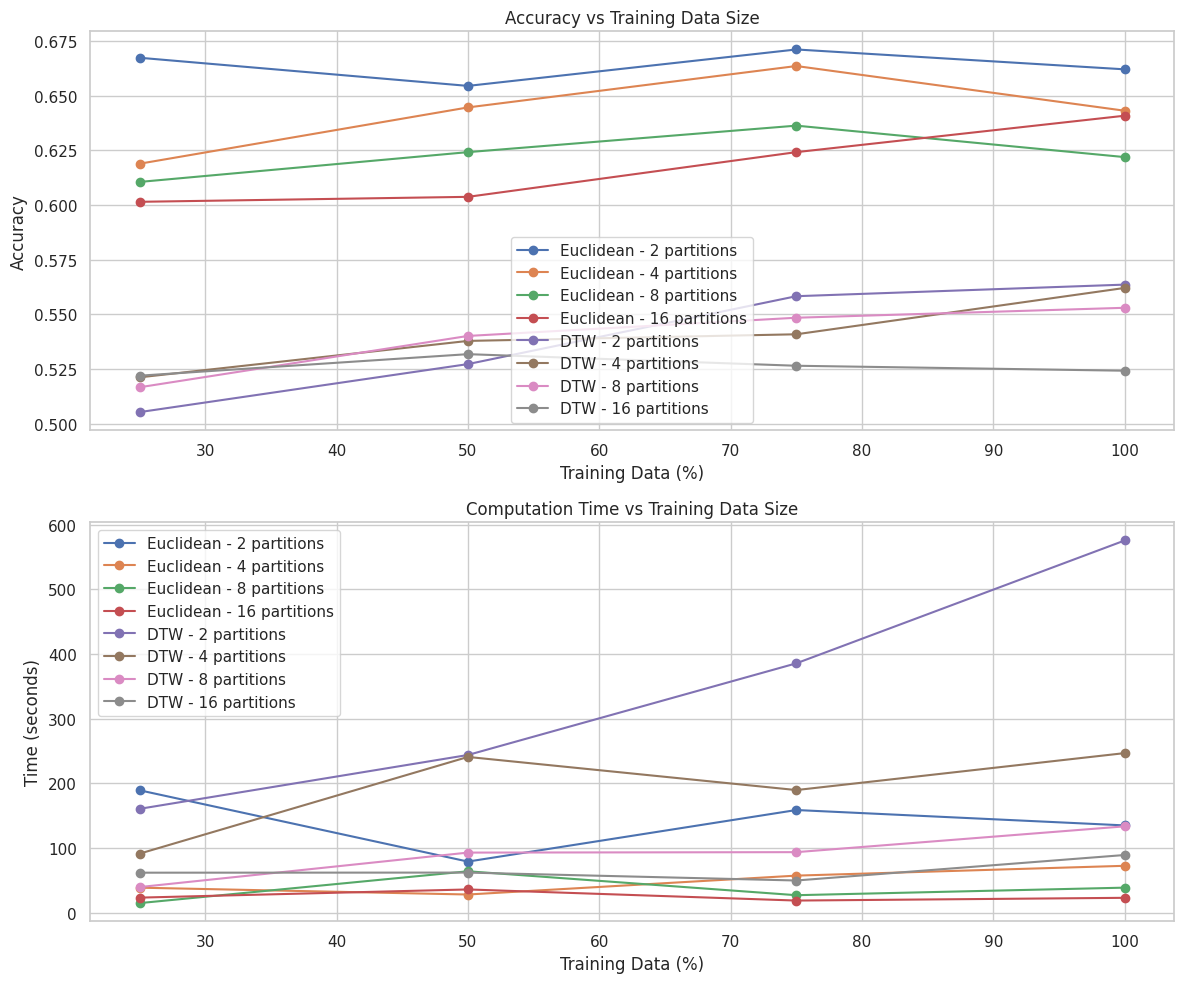

| Fraction | Partitions | Distance   | Accuracy | Time (s) |
|----------|------------|------------|----------|----------|
|   25.0% |          2 | DTW        | 0.5053  |   160.69 |
|   25.0% |          4 | DTW        | 0.5212  |    91.45 |
|   25.0% |          8 | DTW        | 0.5167  |    39.82 |
|   25.0% |         16 | DTW        | 0.5220  |    62.07 |
|   50.0% |          2 | DTW        | 0.5273  |   243.91 |
|   50.0% |          4 | DTW        | 0.5379  |   240.90 |
|   50.0% |          8 | DTW        | 0.5402  |    93.11 |
|   50.0% |         16 | DTW        | 0.5318  |    62.22 |
|   75.0% |          2 | DTW        | 0.5583  |   385.54 |
|   75.0% |          4 | DTW        | 0.5409  |   189.71 |
|   75.0% |          8 | DTW        | 0.5485  |    93.79 |
|   75.0% |         16 | DTW        | 0.5265  |    49.99 |
|  100.0% |          2 | DTW        | 0.5636  |   575.34 |
|  100.0% |          4 | DTW        | 0.5621  |   246.81 |
|  100.0% |          8 | DTW        | 0.5530  |   13

In [0]:
%pip install fastdtw
from pyspark.sql import SparkSession
from pyspark import SparkContext
import numpy as np
import time
import matplotlib.pyplot as plt
from fastdtw import fastdtw

# Initialize Spark
sc = spark.sparkContext

# Data Loading
data_path = "/mnt/2025-team19/"
train_df = spark.read.csv(data_path + "FordA_TRAIN.csv", header=True, inferSchema=True)
test_df = spark.read.csv(data_path + "FordA_TEST.csv", header=True, inferSchema=True)

# Prepare RDDs
train_rdd = train_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 501)]))
test_rdd = test_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 501)]))

# Distance functions
def euclidean_distance(ts1, ts2):
    return float(np.sqrt(np.sum((np.array(ts1) - np.array(ts2))**2)))

def dtw_distance(ts1, ts2):
    distance, _ = fastdtw(ts1, ts2)
    return float(distance)

def distributed_knn(train_rdd, test_rdd, num_partitions, k=1, dist_func=euclidean_distance):
    # 1. Prepare partitioned training data
    partitioned_train = (
        train_rdd
        .map(lambda x: (np.random.randint(0, num_partitions), x))
        .groupByKey()
        .mapValues(list)
        .collectAsMap()
    )
    
    # 2. Broadcast partitions to workers
    broadcast_partitions = sc.broadcast(partitioned_train)
    
    # 3. Process test cases using broadcasted data
    def predict(test_case):
        test_label, test_features = test_case
        partition_id = np.random.randint(0, num_partitions)
        candidates = broadcast_partitions.value.get(partition_id, [])
        
        if not candidates:
            return (test_label, -1)  # Handle empty partitions
        
        distances = [
            (dist_func(test_features, features), label)
            for (label, features) in candidates
        ]
        top_k = sorted(distances, key=lambda x: x[0])[:k]
        labels = [label for (_, label) in top_k]
        return (test_label, max(set(labels), key=labels.count))
    
    return test_rdd.map(predict)

# Experiment parameters
fractions = [0.25, 0.5, 0.75, 1.0]
partitions = [2, 4, 8, 16]
results = []

# Main experiment loop
for frac in fractions:
    for num_parts in partitions:
        # Sample training data
        subset = train_rdd.sample(False, frac, seed=42)
        
        # Run for both distance metrics
        for dist_name, dist_func in [('Euclidean', euclidean_distance),
                                   ('DTW', dtw_distance)]:
            # Time execution
            start_time = time.time()
            predictions = distributed_knn(
                subset,
                test_rdd,
                num_partitions=num_parts,
                k=1,
                dist_func=dist_func
            )
            
            # Calculate accuracy
            correct = predictions.filter(lambda x: x[0] == x[1]).count()
            accuracy = correct / test_rdd.count()
            duration = (time.time() - start_time)
            
            results.append({
                'Fraction': frac,
                'Partitions': num_parts,
                'Distance': dist_name,
                'Accuracy': accuracy,
                'Time': duration
            })

# Visualization and output (same as previous)
# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy plot
for dist_name in ['Euclidean', 'DTW']:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        y = [r['Accuracy'] for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        axs[0].plot(x, y, marker='o', 
                   label=f'{dist_name} - {num_parts} partitions')
axs[0].set_title('Accuracy vs Training Data Size')
axs[0].set_xlabel('Training Data (%)')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Time plot
for dist_name in ['Euclidean', 'DTW']:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        y = [r['Time'] for r in results 
             if r['Partitions'] == num_parts and r['Distance'] == dist_name]
        axs[1].plot(x, y, marker='o', 
                   label=f'{dist_name} - {num_parts} partitions')
axs[1].set_title('Computation Time vs Training Data Size')
axs[1].set_xlabel('Training Data (%)')
axs[1].set_ylabel('Time (seconds)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Results table
print("| Fraction | Partitions | Distance   | Accuracy | Time (s) |")
print("|----------|------------|------------|----------|----------|")
for r in sorted(results, key=lambda x: (x['Distance'], x['Fraction'], x['Partitions'])):
    print(f"| {r['Fraction']*100:6.1f}% | {r['Partitions']:10} | {r['Distance']:10} | {r['Accuracy']:.4f}  | {r['Time']:8.2f} |")

## Sequential Implementation of KNN with DTW/Euclidiean using Python

https://colab.research.google.com/drive/1kqgqSwfghVkXiPB5K0M9_qSJ8YxwRbIe


# Proximity Forest - Distributed & Sequential (Mohamed Arshad Yameen)

1. Data Loading and Preprocessing
- Loading the FordA training and testing CSV files into Spark DataFrames, extracting the time series features, defining a schema, and converting them into structured DataFrames.


In [0]:
data_path = "/mnt/2025-team19/"
train_df = spark.read.csv(data_path + "FordA_TRAIN.csv", header=True, inferSchema=True)
test_df = spark.read.csv(data_path + "FordA_TEST.csv", header=True, inferSchema=True)

parsed_rdd = train_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 501)]))
parsed_test_rdd = test_df.rdd.map(lambda row: (row['Target'], [row[f'C{i}'] for i in range(1, 501)]))

from pyspark.sql.types import StructType, StructField, DoubleType, ArrayType, IntegerType
schema = StructType([
    StructField("label", IntegerType(), False),
    StructField("features", ArrayType(DoubleType()), False)
])

train_parsed_df = spark.createDataFrame(parsed_rdd, schema)
test_parsed_df = spark.createDataFrame(parsed_test_rdd, schema)

2. Converting DataFrames to Python Dict
- Converting the parsed Spark DataFrames into lists of dictionaries, each containing label and features, for compatibility with the custom Proximity Forest implementation.


In [0]:
train_data = [{'label': row['label'], 'features': row['features']} for row in train_parsed_df.collect()]
test_data = [{'label': row['label'], 'features': row['features']} for row in test_parsed_df.collect()]

3. Defining Distance Function
- Defining the Euclidean distance metric to compare time series during tree construction and prediction.




In [0]:
import numpy as np

def euclidean(ts1, ts2):
    return np.sqrt(np.sum((np.array(ts1) - np.array(ts2))**2))



4. Implementing Proximity Tree
- Defining the ProximityTreeNode class, which builds a decision tree by recursively splitting data based on distance thresholds to random reference series.


In [0]:
import random

class ProximityTreeNode:
    def __init__(self, depth=0, max_depth=5):
        self.left = None
        self.right = None
        self.reference_series = None
        self.threshold = None
        self.label = None
        self.depth = depth
        self.max_depth = max_depth

    def fit(self, data, dist_func=euclidean):
        labels = [row['label'] for row in data]
        if len(set(labels)) == 1 or self.depth >= self.max_depth:
            self.label = max(set(labels), key=labels.count)
            return

        self.reference_series = random.choice(data)['features']
        distances = [(row, dist_func(self.reference_series, row['features'])) for row in data]
        distances.sort(key=lambda x: x[1])
        self.threshold = distances[len(distances)//2][1]

        left_data = [row for row, d in distances if d <= self.threshold]
        right_data = [row for row, d in distances if d > self.threshold]

        self.left = ProximityTreeNode(self.depth + 1, self.max_depth)
        self.right = ProximityTreeNode(self.depth + 1, self.max_depth)

        if left_data:
            self.left.fit(left_data, dist_func)
        if right_data:
            self.right.fit(right_data, dist_func)

    def predict(self, features, dist_func=euclidean):
        if self.label is not None:
            return self.label
        dist = dist_func(self.reference_series, features)
        if dist <= self.threshold:
            return self.left.predict(features, dist_func)
        else:
            return self.right.predict(features, dist_func)

5. Proximity Forest Functions
- Implementing functions to train a forest of proximity trees, predict using majority voting, evaluate accuracy, and train in parallel using Spark.


In [0]:
def train_forest(train_data, n_trees=5, max_depth=5, dist_func=euclidean):
    forest = []
    for _ in range(n_trees):
        sampled_data = random.choices(train_data, k=len(train_data)) 
        tree = ProximityTreeNode(depth=0, max_depth=max_depth)
        tree.fit(sampled_data, dist_func)
        forest.append(tree)
    return forest
  
def predict_forest(forest, sample, dist_func=euclidean):
    predictions = [tree.predict(sample['features'], dist_func) for tree in forest]
    return max(set(predictions), key=predictions.count)
  

def evaluate_forest(forest, test_data, dist_func=euclidean):
    correct = 0
    total = len(test_data)
    for row in test_data:
        pred = predict_forest(forest, row, dist_func)
        if pred == row['label']:
            correct += 1
    return correct / total


def train_proximity_forest_spark(train_data, n_trees=5, max_depth=5, dist_func=euclidean):
    from pyspark import SparkContext
    sc = spark.sparkContext
    broadcast_data = sc.broadcast(train_data)

    def train_single_tree(_):
        sampled = random.choices(broadcast_data.value, k=len(broadcast_data.value))
        tree = ProximityTreeNode(depth=0, max_depth=max_depth)
        tree.fit(sampled, dist_func)
        return tree

    forest_rdd = sc.parallelize(range(n_trees)).map(train_single_tree)
    return forest_rdd.collect()

6. Train and Evaluate Proximity Forests
- Training Proximity Forest with 15 trees and evaluating its performance on the test set (Sequential version).




In [0]:
forest = train_forest(train_data, n_trees=15, max_depth=5)
accuracy = evaluate_forest(forest, test_data)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6121


7. Subsampling and Evaluation
- Training a Spark-parallel Proximity Forest with 15 trees and evaluating its performance on the test set.



In [0]:
import time

def sample_and_evaluate_spark(train_data, test_data, frac, n_trees=15, depth=5, dist_func=euclidean):
    sample_size = int(len(train_data) * frac)
    sampled_train = random.sample(train_data, sample_size)

    start = time.time()
    forest = train_proximity_forest_spark(sampled_train, n_trees=n_trees, max_depth=depth, dist_func=dist_func)
    train_time = time.time() - start

    accuracy = evaluate_forest(forest, test_data, dist_func)
    return accuracy, train_time


8. Scalability Experiments: Data Size × Partition Count
- Looping over combinations of data fractions and Spark partitions to assess scalability in terms of training time and accuracy.


In [0]:
fractions = [0.25, 0.5, 0.75, 1.0]
partitions = [2, 4, 8, 16]
results = []

for frac in fractions:
    for num_parts in partitions:
        subset_size = int(len(train_data) * frac)
        subset_data = train_data[:subset_size]
        
        subset_data_spark = spark.createDataFrame(subset_data).repartition(num_parts)

        start_time = time.time()
        subset_df_list = [{'label': row['label'], 'features': row['features']} for row in subset_data_spark.collect()]
        forest = train_proximity_forest_spark(subset_df_list, n_trees=15, max_depth=5)
        training_time = time.time() - start_time
        
        accuracy = evaluate_forest(forest, test_data)
        
        results.append((frac, num_parts, accuracy, training_time))




9. Display Results Table
- Printing a table summarizing accuracy and training time for each fraction/partition combination.




In [0]:
print("Fraction | Partitions | Accuracy | Training Time (s)")
print("-" * 50)

for frac, num_parts, acc, t in results:
    print(f"{frac*100:>7.0f}%   | {num_parts:>10} | {acc:.4f}   | {t:.2f}")


Fraction | Partitions | Accuracy | Training Time (s)
--------------------------------------------------
     25%   |          2 | 0.5970   | 1.79
     25%   |          4 | 0.6341   | 1.92
     25%   |          8 | 0.6167   | 2.78
     25%   |         16 | 0.5985   | 3.62
     50%   |          2 | 0.6258   | 5.55
     50%   |          4 | 0.6015   | 44.73
     50%   |          8 | 0.6364   | 8.15
     50%   |         16 | 0.6242   | 7.93
     75%   |          2 | 0.6371   | 5.57
     75%   |          4 | 0.6258   | 2.81
     75%   |          8 | 0.6273   | 2.95
     75%   |         16 | 0.6250   | 2.56
    100%   |          2 | 0.6492   | 9.32
    100%   |          4 | 0.6189   | 6.41
    100%   |          8 | 0.6265   | 4.71
    100%   |         16 | 0.6470   | 3.63


%md
10. Plot Results (Scalability Visualization)
- Generating a plot visualizing how training time and accuracy vary with dataset size and parallelism level.



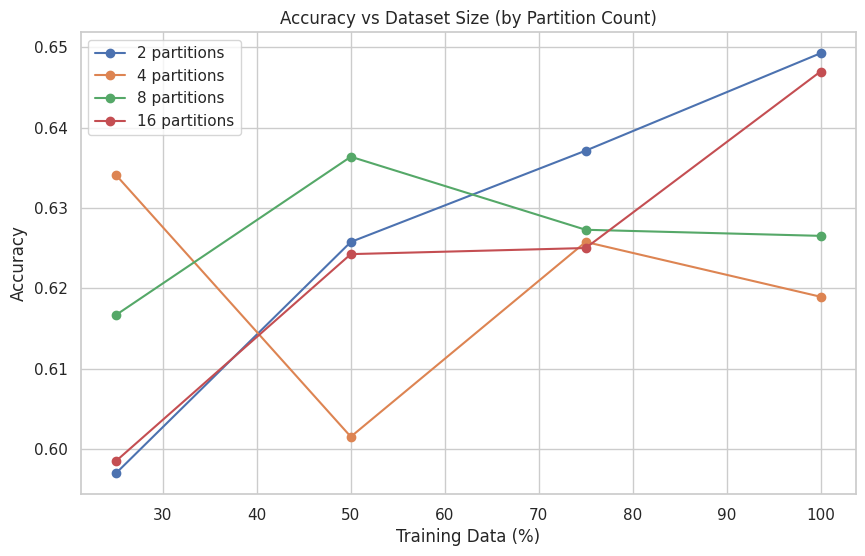

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for num_parts in partitions:
    sizes = [int(f*100) for f, p, _, _ in results if p == num_parts]
    accs  = [a for f, p, a, _ in results if p == num_parts]
    
    plt.plot(sizes, accs, marker='o', label=f'{num_parts} partitions')

plt.title("Accuracy vs Dataset Size (by Partition Count)")
plt.xlabel("Training Data (%)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

11. Forest Size Impact on Performance (Sequential)
- Evaluating how varying the number of trees affects accuracy and training time, and visualize the results using line plots.


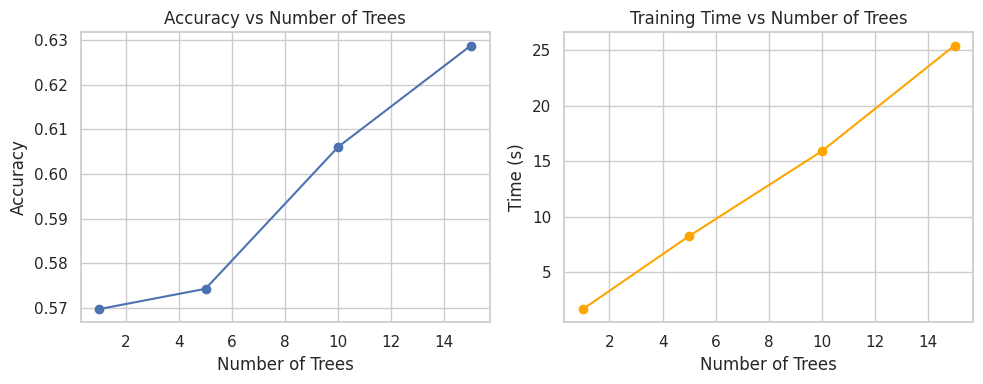

In [0]:
import time

tree_counts = [1, 5, 10, 15]
results = []

for n in tree_counts:
    start = time.time()
    forest = train_forest(train_data, n_trees=n, max_depth=5)
    elapsed = time.time() - start
    acc = evaluate_forest(forest, test_data)
    results.append((n, acc, elapsed))

# Plot
import matplotlib.pyplot as plt

trees = [r[0] for r in results]
accs = [r[1] for r in results]
times = [r[2] for r in results]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(trees, accs, marker='o')
plt.title("Accuracy vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(trees, times, marker='o', color='orange')
plt.title("Training Time vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

12. Forest Size Impact on Performance (Distributed)
- Evaluating how varying the number of trees affects accuracy and training time, and visualize the results using line plots.


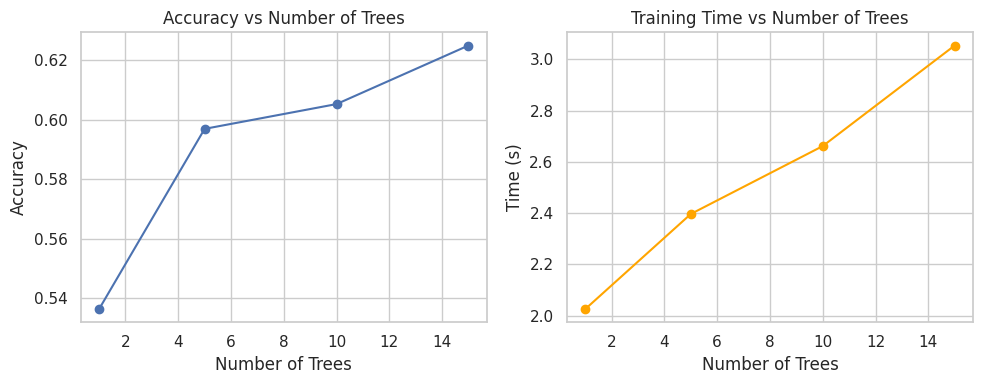

In [0]:
import time

tree_counts = [1, 5, 10, 15]
results = []

for n in tree_counts:
    start = time.time()
    forest = train_proximity_forest_spark(train_data, n_trees=n, max_depth=5)
    elapsed = time.time() - start
    acc = evaluate_forest(forest, test_data)
    results.append((n, acc, elapsed))

# Plot
import matplotlib.pyplot as plt

trees = [r[0] for r in results]
accs = [r[1] for r in results]
times = [r[2] for r in results]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(trees, accs, marker='o')
plt.title("Accuracy vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(trees, times, marker='o', color='orange')
plt.title("Training Time vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()

11. Visual Evaluation: Confusion Matrix
- Ploting a confusion matrix to understand the model’s classification behavior and error distribution.




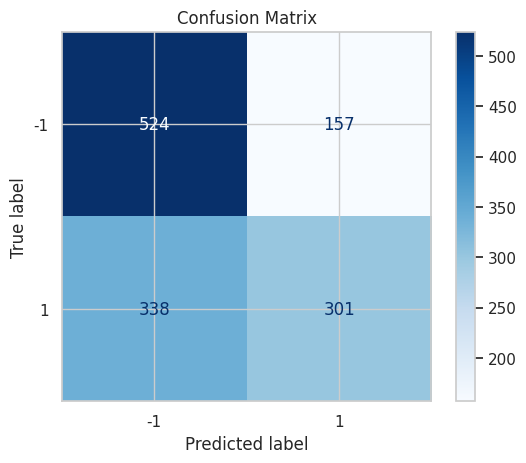

In [0]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = [row['label'] for row in test_data]
y_pred = [predict_forest(forest, row) for row in test_data]

cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-1, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# MLlib - Decision Tree, Random Forest, Logistic Regression (Mrunal Srikumar Mesharam)

Training label distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0| 1846|
|    1| 1755|
+-----+-----+

Test label distribution:
+-----+-----+
|label|count|
+-----+-----+
|    0|  681|
|    1|  639|
+-----+-----+



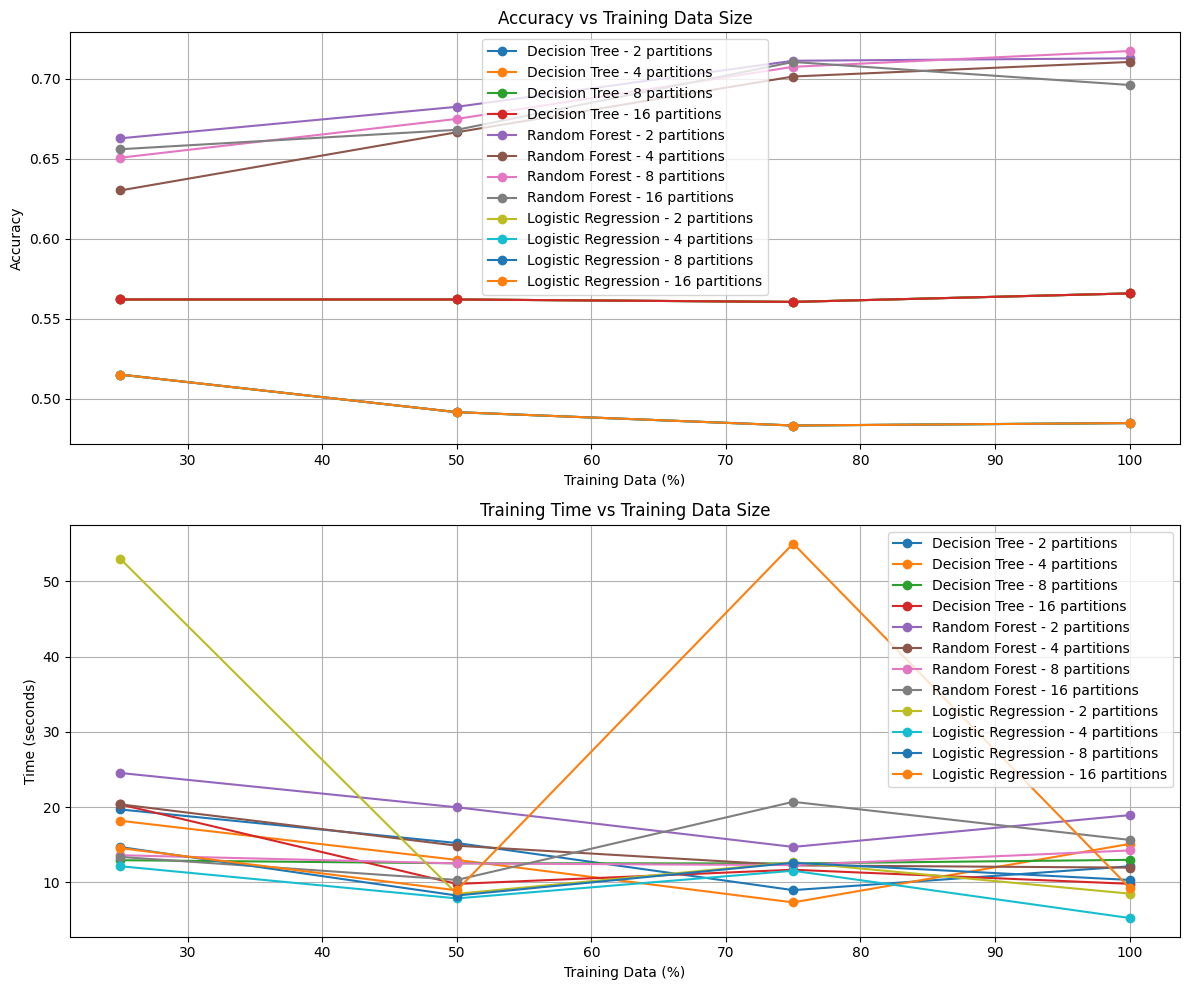

| Fraction | Partitions | Model               | Accuracy | Time (s) |
|----------|------------|---------------------|----------|----------|
|   25.0% |          2 | Decision Tree       | 0.5621  |    19.69 |
|   25.0% |          4 | Decision Tree       | 0.5621  |    18.19 |
|   25.0% |          8 | Decision Tree       | 0.5621  |    12.95 |
|   25.0% |         16 | Decision Tree       | 0.5621  |    20.36 |
|   50.0% |          2 | Decision Tree       | 0.5621  |    15.24 |
|   50.0% |          4 | Decision Tree       | 0.5621  |    12.99 |
|   50.0% |          8 | Decision Tree       | 0.5621  |    12.54 |
|   50.0% |         16 | Decision Tree       | 0.5621  |     9.80 |
|   75.0% |          2 | Decision Tree       | 0.5606  |     8.97 |
|   75.0% |          4 | Decision Tree       | 0.5606  |     7.35 |
|   75.0% |          8 | Decision Tree       | 0.5606  |    12.52 |
|   75.0% |         16 | Decision Tree       | 0.5606  |    11.69 |
|  100.0% |          2 | Decision Tree      

In [0]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
import time
import matplotlib.pyplot as plt

# Initialize Spark
sc = spark.sparkContext

# Data Loading
data_path = "/mnt/2025-team19/"

# Load and convert data with proper label encoding
def load_and_convert(path):
    df = spark.read.csv(path, header=True, inferSchema=True)
    return df.rdd.map(lambda row: (
        0 if row['Target'] == -1 else 1,  # Convert labels to 0/1
        Vectors.dense([row[f'C{i}'] for i in range(1, 500)])
    )).toDF(["label", "features"])

# Prepare datasets
train_df = load_and_convert(data_path + "FordA_TRAIN.csv").cache()
test_df = load_and_convert(data_path + "FordA_TEST.csv").cache()

# Verify label conversion
print("Training label distribution:")
train_df.groupBy("label").count().show()
print("Test label distribution:")
test_df.groupBy("label").count().show()

# Experiment function
def run_experiment(model_type, train_data, test_data, num_partitions):
    start_time = time.time()
    
    # Repartition training data
    partitioned_data = train_data.repartition(num_partitions)
    
    # Initialize model
    if model_type == "dt":
        model = DecisionTreeClassifier(
            labelCol="label",
            featuresCol="features",
            maxDepth=10
        )
    elif model_type == "rf":
        model = RandomForestClassifier(
            labelCol="label",
            featuresCol="features",
            numTrees=50,
            maxDepth=10
        )
    elif model_type == "lr":
        model = LogisticRegression(
            labelCol="label",
            featuresCol="features",
            maxIter=10
        )
    
    # Train model
    trained_model = model.fit(partitioned_data)
    training_time = time.time() - start_time
    
    # Evaluate
    predictions = trained_model.transform(test_data)
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy"
    )
    accuracy = evaluator.evaluate(predictions)
    
    return accuracy, training_time

# Experiment parameters
fractions = [0.25, 0.5, 0.75, 1.0]
partitions = [2, 4, 8, 16]
results = []
model_name_map = {
    "dt": "Decision Tree",
    "rf": "Random Forest",
    "lr": "Logistic Regression"
}

# Main experiment loop
for frac in fractions:
    for num_parts in partitions:
        # Sample data
        subset = train_df.sample(fraction=frac, seed=42)
        
        # Run experiments for all models
        for model_type in ["dt", "rf", "lr"]:
            start_time = time.time()
            
            acc, train_time = run_experiment(
                model_type, 
                subset.repartition(num_parts), 
                test_df,
                num_parts
            )
            
            total_time = (time.time() - start_time)
            
            results.append({
                'Fraction': frac,
                'Partitions': num_parts,
                'Model': model_name_map[model_type],
                'Accuracy': acc,
                'Time': total_time
            })

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Accuracy plot
for model_name in ["Decision Tree", "Random Forest", "Logistic Regression"]:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Model'] == model_name]
        y = [r['Accuracy'] for r in results 
             if r['Partitions'] == num_parts and r['Model'] == model_name]
        axs[0].plot(x, y, marker='o', 
                   label=f'{model_name} - {num_parts} partitions')
axs[0].set_title('Accuracy vs Training Data Size')
axs[0].set_xlabel('Training Data (%)')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# Time plot
for model_name in ["Decision Tree", "Random Forest", "Logistic Regression"]:
    for num_parts in partitions:
        x = [r['Fraction']*100 for r in results 
             if r['Partitions'] == num_parts and r['Model'] == model_name]
        y = [r['Time'] for r in results 
             if r['Partitions'] == num_parts and r['Model'] == model_name]
        axs[1].plot(x, y, marker='o', 
                   label=f'{model_name} - {num_parts} partitions')
axs[1].set_title('Training Time vs Training Data Size')
axs[1].set_xlabel('Training Data (%)')
axs[1].set_ylabel('Time (seconds)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Results table
print("| Fraction | Partitions | Model               | Accuracy | Time (s) |")
print("|----------|------------|---------------------|----------|----------|")
for r in sorted(results, key=lambda x: (x['Model'], x['Fraction'], x['Partitions'])):
    print(f"| {r['Fraction']*100:6.1f}% | {r['Partitions']:10} | {r['Model']:19} | {r['Accuracy']:.4f}  | {r['Time']:8.2f} |")